#### [Соревнование по распознаванию ростков растений](https://www.kaggle.com/c/plant-seedlings-classification)

In [2]:
import os
import shutil
import pandas as pd
import torch
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import transforms

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
df = []
for label in os.listdir('train'):
    for pic in os.listdir(f'train/{label}'):
        df.append([label, pic])

df = pd.DataFrame(df, columns = ['label', 'pic'])

In [17]:
df.head()

,label,pic
0,Sugar beet,6d99bec4e.png
1,Sugar beet,02460681c.png
2,Sugar beet,de1da036c.png
3,Sugar beet,7c05c4f0e.png
4,Sugar beet,71b1b6718.png


In [18]:
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(df.index, test_size=0.2, random_state=57, shuffle=True, stratify=df.label)


for idx in val_idx:
    picture = df.pic.loc[idx]
    folder = df.label.loc[idx]
    if not os.path.exists(f'val/{folder}'):
        os.mkdir(f'val/{folder}')
    shutil.move(f"train/{folder}/{picture}", f"val//{folder}/{picture}")

In [19]:
train_idx

Int64Index([3195,   43,  817, 2872, 2099, 2019,   40, 1188, 4118,   81,
            ...
            4431,  847, 3952, 4011, 1072, 3899, 3101, 1733,  115, 2441],
           dtype='int64', length=3800)

In [44]:
from torchvision import datasets


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(200),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(235),
        transforms.CenterCrop(200),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}


image_datasets = {x: datasets.ImageFolder(x, data_transforms[x]) for x in ['train', 'val']}

In [67]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)
class_names = image_datasets['train'].classes

{'train': 3800, 'val': 950}


In [68]:
len(class_names)

12

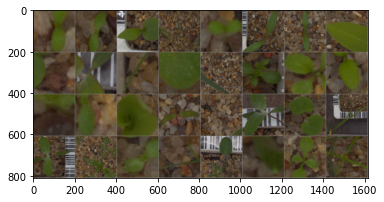

Scentless Mayweed  Scentless Mayweed  Maize  Loose Silky-bent  Scentless Mayweed  Sugar beet  Sugar beet  Maize  Cleavers  Fat Hen  Loose Silky-bent  Small-flowered Cranesbill  Common wheat  Shepherds Purse  Shepherds Purse  Common Chickweed  Scentless Mayweed  Scentless Mayweed  Maize  Fat Hen  Black-grass  Fat Hen  Small-flowered Cranesbill  Black-grass  Fat Hen  Scentless Mayweed  Scentless Mayweed  Loose Silky-bent  Cleavers  Common wheat  Shepherds Purse  Black-grass


In [69]:
import matplotlib.pyplot as plt


def imshow(img):
    # убрать нормализацию
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# взять случайный батч изображений
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('  '.join('{}'.format(class_names[labels[j]]) for j in range(32)))

In [70]:
import time
import copy


def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [77]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 18, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(18, 54, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(54, 162, 3, padding=1)
        self.pool4 = nn.MaxPool2d(25, 25)
        self.fc1 = nn.Linear(162, 44)
        self.fc2 = nn.Linear(44, 12)

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = F.relu(self.pool3(self.conv3(x)))
        x = F.relu(self.pool4(self.conv4(x)))
        x = x.view(-1, 162)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net().to(device)

In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [79]:
net = train_model(net, criterion, optimizer,  num_epochs=100)

Epoch 0/99
----------
train Loss: 2.3321 Acc: 0.1837
val Loss: 1.9783 Acc: 0.2884

Epoch 1/99
----------
train Loss: 1.9227 Acc: 0.3174
val Loss: 1.7513 Acc: 0.3495

Epoch 2/99
----------
train Loss: 1.8412 Acc: 0.3382
val Loss: 1.7491 Acc: 0.3832

Epoch 3/99
----------
train Loss: 1.7808 Acc: 0.3603
val Loss: 1.6250 Acc: 0.4242

Epoch 4/99
----------
train Loss: 1.6544 Acc: 0.4045
val Loss: 1.4801 Acc: 0.4789

Epoch 5/99
----------
train Loss: 1.5465 Acc: 0.4492
val Loss: 1.4484 Acc: 0.4958

Epoch 6/99
----------
train Loss: 1.4965 Acc: 0.4871
val Loss: 1.4175 Acc: 0.4800

Epoch 7/99
----------
train Loss: 1.3924 Acc: 0.5229
val Loss: 1.2270 Acc: 0.5516

Epoch 8/99
----------
train Loss: 1.3403 Acc: 0.5411
val Loss: 1.1748 Acc: 0.5789

Epoch 9/99
----------
train Loss: 1.2768 Acc: 0.5592
val Loss: 1.1480 Acc: 0.6000

Epoch 10/99
----------
train Loss: 1.2539 Acc: 0.5584
val Loss: 1.0340 Acc: 0.6695

Epoch 11/99
----------
train Loss: 1.1809 Acc: 0.5924
val Loss: 0.9742 Acc: 0.6758

Ep

In [96]:
PATH = './leaves_net.pth'
torch.save(net.state_dict(), PATH)

In [82]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet


In [117]:
test_dataset = datasets.ImageFolder('test', data_transforms['val'])
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [118]:
result = []
net.eval()
for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        result = result + preds.cpu().numpy().tolist()

In [130]:
pred = [[name[0].split('/')[-1], class_names[result[idx]]] for idx, name in enumerate(test_dataset.imgs)]
pred = pd.DataFrame(pred, columns=['file', 'species'])
pred.head()

,file,species
0,0021e90e4.png,Small-flowered Cranesbill
1,003d61042.png,Fat Hen
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Common Chickweed
4,00c47e980.png,Sugar beet


In [131]:
pred.to_csv('submission.csv', index=False)

### Скор 0.91687